In [1]:
# imports: 
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0);

---
# Example problem

- Given some inputs called features: x
- Given some inputs called labels: y
- Learn a NN-based function between x and y

In [2]:
# Load training data and convert to torch.tensor
x_train = torch.tensor(np.load('data/x_train.npy'))
y_train = torch.tensor(np.load('data/y_train.npy'))
                  
# Load test data
x_test = torch.tensor(np.load('data/x_test.npy'))
y_test = torch.tensor(np.load('data/y_test.npy'))


In [3]:
# Check shape of x_train: Number of samples x Features dimension
x_train.shape

torch.Size([200, 2])

In [4]:
# Check shape of y_train: Number of samples x Labels dimension
y_train.shape

torch.Size([200, 2])

In [5]:
def plot_3d(x, y, nn=None):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    def helper(ax,index):
        if nn is not None:
            X1, X2 = np.meshgrid(np.linspace(0, 1, 30), np.linspace(0, 1, 30))
            x_grid = torch.stack((torch.tensor(X1.flatten()),torch.tensor(X2.flatten()))).t().float()
            y_grid = nn(x_grid)
            Z = y_grid[:,index].detach().numpy().reshape((30,30))
            ax.contour3D(X1, X2, Z, 100, cmap='viridis')
            ax.scatter3D(x[:,0], x[:,1].detach(), y[:,index].detach(), c='r');
        else:
            ax.scatter3D(x[:,0], x[:,1].detach(), y[:,index].detach(), c=y[:,index].detach(), cmap='plasma')
        ax.set_title('Label dim: {}'.format(index))
        ax.set_xlabel('x0'); ax.set_ylabel('x1'); ax.set_zlabel('y{}'.format(index))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    helper(ax,0)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    helper(ax,1)

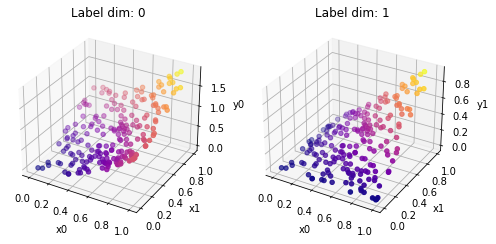

In [6]:
# Visualize first label as a function of features
plot_3d(x_train, y_train)

## Always check the shape of data and visualize the data

----

## Lets now create a NN model (similar to polynomial model)

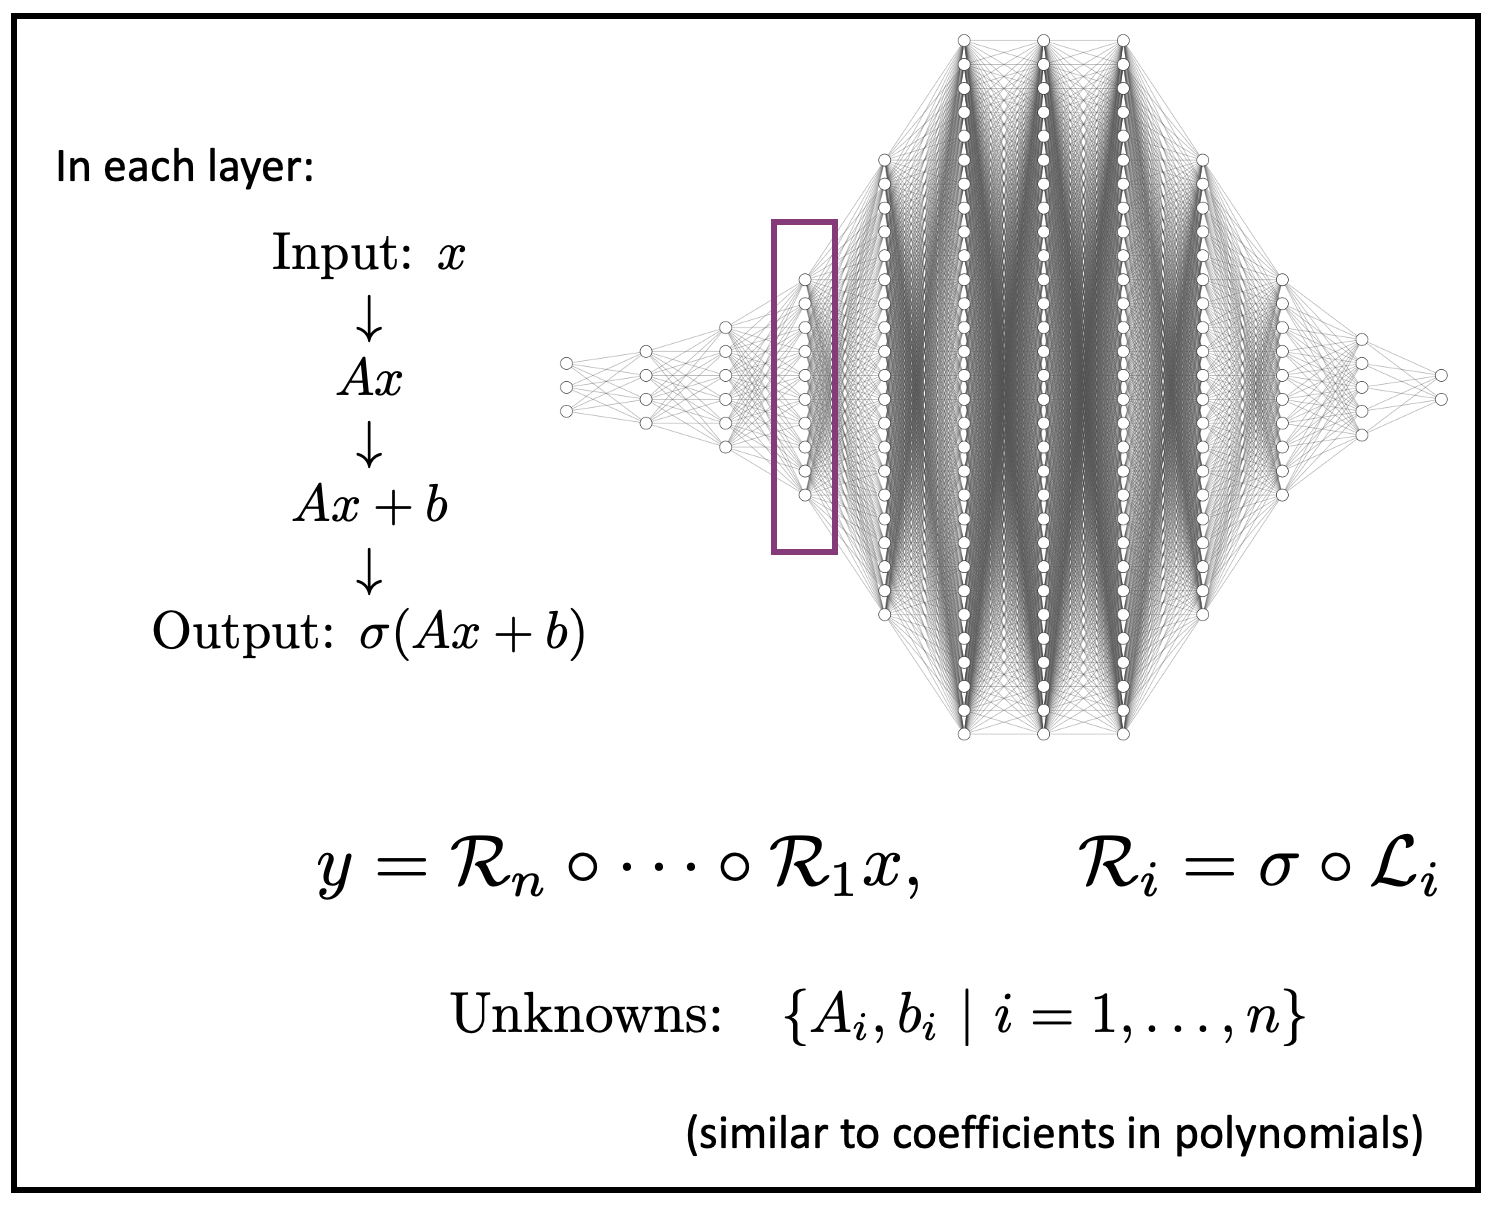

In [7]:
# Create a NN model

# Recall: NN is repeated linear and nonlinear (e.g., ReLU) transformations
# The first and last layer dimensions are determined by feature and label dimensions

nn = torch.nn.Sequential(
    torch.nn.Linear(2,8),
    torch.nn.ReLU(),
    torch.nn.Linear(8,16),
    torch.nn.ReLU(),
    torch.nn.Linear(16,6),
    torch.nn.ReLU(),
    torch.nn.Linear(6,2)
)

#----------------------------------------------
print('Neural network:\n\n',nn)

Neural network:

 Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=2, bias=True)
)


## Never end a NN with activation function!

### Train a NN model:

In [8]:
# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.01

# Optimizer: use Adam
optimizer = torch.optim.Adam(nn.parameters(), lr = lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = torch.nn.MSELoss()

# number of steps, the proper term is 'EPOCH'
num_epochs = 1000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = nn(x_train)
    
    # Compute the loss. 
    train_loss = loss_function(y_train_pred, y_train)
    
    
    # store the loss in a list
    train_loss_history.append(train_loss.detach().item())
    
    
    # Call .backward() on loss to compute gradient (d_loss/d_a)
    train_loss.backward()
            
    # Update the model paramaeters 
    # No need for torch.no_grad() anymore with in-built optimizers
    optimizer.step()
    
    # remove any pre-exisitng gradients stored
    optimizer.zero_grad()
    
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad(): #torch.no_grad() is back because we don't train on test data and so don't need gradients
        
        # Make your predictions
        y_test_pred = nn(x_test)
        
        # Compute the loss. 
        test_loss = loss_function(y_test_pred, y_test)
        
        
        # store the loss in a list
        test_loss_history.append(test_loss.detach().item())
        

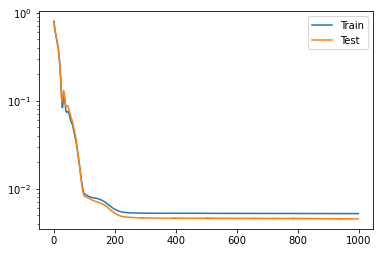

In [9]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test'])

### Evaluating prediction accuracy:

***Note: Evaluate on test data not used during training***

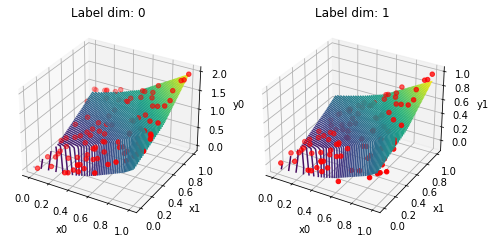

In [10]:
# Visualize predictions on test data
plot_3d(x_test, y_test, nn)

In [11]:
def calculate_R2(true, pred):
    # Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2(true, pred):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('Label dim: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    ax = fig.add_subplot(1, 2, 1)
    helper(ax,0)
    ax = fig.add_subplot(1, 2, 2)
    helper(ax,1)
    fig.tight_layout()

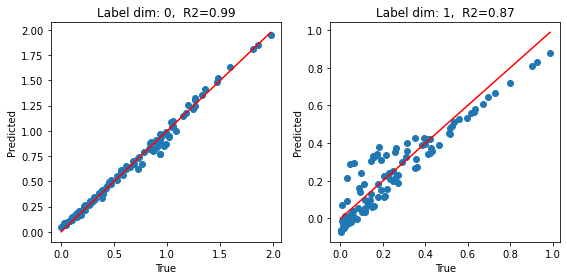

In [12]:
# Make prediction on test set
y_tset_pred = nn(x_test)

# Visualize accuracy
plotR2(y_test, y_test_pred)

---
### ***Note: Always test your model on data that has not been used during training***
---

### $R^2$ is the coefficient of determination. In ideal case with 100% accuracy, all points in above plot will lie on line with slope=1 and intercept = 0. This corresponds to $R^2=1$. 0% accuracy will mean $R^2=0$.

---


In [13]:
# Print trained NN parameters (Dont do this for large NNs)
list(nn.parameters())

[Parameter containing:
 tensor([[ 0.6304,  0.7960],
         [-0.2918, -0.0466],
         [-0.2723,  0.1896],
         [ 0.8818,  0.8526],
         [ 0.5149,  0.4344],
         [ 0.2091,  0.1074],
         [-0.6755, -0.4683],
         [-0.8075,  0.3418]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3564,  0.6428, -0.4794, -0.2635,  0.2096,  0.5595, -0.1455,  0.8532],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.4890, -0.4846,  0.3201,  0.7312, -0.0769, -0.9090, -0.1378,  1.3579],
         [-0.3594, -0.3298, -0.2470, -0.4377, -0.3263,  0.1762,  0.1578,  0.0514],
         [-0.0041, -0.3075,  0.0598, -0.2420, -0.3041, -0.2570,  0.2231,  0.1288],
         [-0.2489, -0.1048,  0.2261,  0.2594,  0.0482, -0.0443,  0.2371, -0.2998],
         [-0.0467, -0.3615, -0.2450, -0.2760,  0.0486,  0.0250, -0.2094, -0.0210],
         [ 0.5393, -0.1714,  0.0135,  0.7004,  0.5366,  0.4614, -0.2725, -0.3867],
         [ 0.4140,  0.0697,  0.3077,  0.8871,  0.3173, -0.2524,  0.0

In [14]:
# Total number of NN parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(nn)

284